In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import cv2

import sys, os, itertools, pickle
from pprint import pprint

from util import *
from config import *
from putil import *
%load_ext autoreload
%aimport util
%aimport putil
%aimport config
%autoreload 1

In [2]:
def next_k(it, k):
    return [next(it) for _ in range(k)][-1]

def show_img(imgs, figsize=(12, 9)):
    if type(imgs) != list:
        imgs = [imgs]
    plt.figure(figsize=figsize)
    alpha = 1
    alpha_dec = 1 / len(imgs)
    for img in imgs:
        plt.imshow(img, alpha=alpha)
        alpha -= alpha_dec
    plt.axis('off')
    plt.show()
    
def to_homo(x):
    for axis, size in enumerate(x.shape):
        if size == 2:
            break
    else:
        raise RuntimeError()
    ones_shape = list(x.shape)
    ones_shape[axis] = 1
    return np.concatenate((x, np.ones(ones_shape)), axis=axis)

def mult_homo(M, x):
    n, d = x.shape
    if d == 2:
        x = to_homo(x)
    output = np.dot(x, M.T)
    return output[:, :2] / output[:, 2:3]

In [ ]:
cached_frames_path = Root + 'cached_frames.p'
if os.path.exists(cached_frames_path):
    frames = load_pickle(cached_frames_path)
else:
    frames = {}
    for serie in 'pool_room', 'cory_breezeway', 'soda_front':
        calibrated_dir = Data + serie + '/calibrated/'
        videos = [read_video(get_data_path(calibrated_dir, i, name_is_dir=True)) for i in Cam_ids]
        k = 200
        for cam, video in zip(Cam_ids, videos):
            for i, frame in enumerate(video):
                if i % k == 0:
                    frames.setdefault((serie, i), {})[cam] = np.array(frame)
        for video in videos:
            video.close()
    save_pickle(frames, cached_frames_path)

In [4]:
calibrated_dir = Data + 'pool_room/calibrated/'
videos = [read_video(get_data_path(calibrated_dir, i, name_is_dir=True)) for i in Cam_ids]
fs = [np.array(next(iter(v))) for v in videos]
for video in videos:
    video.close()

In [6]:
cameras = { i : load_camera_matrix(i) for i in Cam_ids }

In [7]:
I = np.eye(3)
z = np.zeros(3)
Rts_test = [
    (I, z),
    (np.array([-I[1], -I[2], I[0]]), z),
    (np.array([-I[1], I[2], -I[0]]), z),
    (np.array([I[2], -I[0], -I[1]]), z),
    (np.array([I[2], I[0], I[1]]), z),
    (np.array([I[0], -I[1], -I[2]]), z),
]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


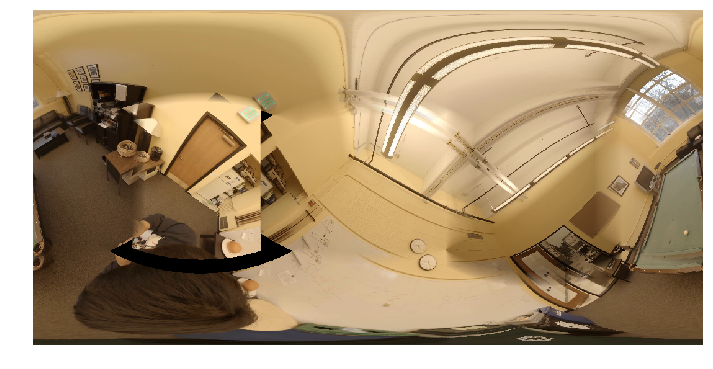

In [8]:
scale = 3
p_w, p_h = 360 * scale, 180 * scale
px_to_rad = lambda x: x / scale * np.pi / 180

weighted_points = {}
in_range = lambda x, min_x, max_x: min_x <= x < max_x
is_inbound = lambda x, y: (0 <= x < Video_width) and (0 <= y < Video_height)
for i in range(p_w):
    theta = px_to_rad(i - p_w // 2) 
    for j in range(p_h):
        phi = px_to_rad(j - p_h // 2)
        vec = np.array([np.sin(theta) * np.cos(phi), np.sin(phi), np.cos(theta) * np.cos(phi)])

        for c, f, (R, t) in zip(Cam_ids, fs, Rts_test):
            if R is None or t is None:
                continue
            x_t, y_t, z_t = np.dot(R, vec)
            camera_matrix = cameras[c]
            f_x, f_y, _ = np.diag(camera_matrix)
            p_x, p_y, _ = camera_matrix[:, 2]
            if z_t > 0:
                x_f = int(round(x_t / z_t * f_x + p_x))
                y_f = int(round(y_t / z_t * f_y + p_y))
                if is_inbound(x_f, y_f):
                    weight = float(min(x_f, Video_width - x_f - 1, y_f, Video_height - y_f - 1))
                    weighted_points.setdefault((j, i), []).append((f[y_f, x_f], weight))
                    continue
panorama = np.zeros((p_h, p_w, 3), dtype=np.uint8)
for (j, i), pixels in weighted_points.items():
    total_weight = sum(w for pix, w in pixels)
    weighted_pixel = sum(pix * w for pix, w in pixels) / total_weight
    panorama[j, i] = weighted_pixel.astype(np.uint8)
show_img(panorama)